In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

leggo il dataset e stampo un campione (prime 5 righe)

In [2]:
df = pd.read_csv('sms_dataset.csv', encoding="ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
198,ham,Hi its Kate how is your evening? I hope i can ...,NaN,NaN,NaN
4467,ham,Much better now thanks lol,NaN,NaN,NaN
4548,ham,"Haha, my friend tyler literally just asked if ...",NaN,NaN,NaN
2516,ham,Yes.i'm in office da:),NaN,NaN,NaN
2177,ham,Oh k :)why you got job then whats up?,NaN,NaN,NaN


numero righe e colonne del dataset

In [3]:
df.shape

(5572, 5)

## Data Cleaning

stampo le info del dataset per fare una panoramica

In [4]:
df.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

si può notare che ci sono delle colonne inutili (ultime 3), quindi vanno eliminate

In [5]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
3493,spam,You are being contacted by our dating service ...
2660,ham,Want to finally have lunch today?
4999,ham,Well its not like you actually called someone ...
913,ham,Ok lor but not too early. Me still having proj...
2224,ham,"I prefer my free days... Tues, wed, fri oso ca..."


rinomino le colonne v1 e v2 con nomi migliori

In [6]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
2474,ham,"Princess, i like to make love &lt;#&gt; time..."
1708,ham,How's my loverboy doing ? What does he do that...
3897,ham,Otherwise had part time job na-tuition..
4719,ham,Forgot to tell Ì_ smth.. Can Ì_ like number th...
3900,ham,That depends. How would you like to be treated...


ora devo traformare il target "ham/spam" in codifica binaria 0/1 quindi ho bisogno di sickitLearn e più nello specifico di LabelEncoder che viene utilizzato per convertire etichette categoriche in numeri interi in modo che possano essere utilizzate come input per algoritmi di machine learning. 


In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [8]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
1434,0,I asked sen to come chennai and search for job.
5000,0,"Nope. Since ayo travelled, he has forgotten hi..."
3946,0,"Sorry, went to bed early, nightnight"
606,1,XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...
5468,1,URGENT! Last weekend's draw shows that you hav...


quindi ora gli spam saranno indicati come 1, gli ham come 0

controllo se sono presenti valori nulli o duplicati, e nel caso risolvo

In [9]:
df.isnull().sum()

target    0
text      0
dtype: int64

non ci sono valori nulli, procedo a verificare eventuali duplicati

In [10]:
df.duplicated().sum()

403

procedo a rimuovere i 403 duplicati

In [11]:
df = df.drop_duplicates(keep='first')

In [12]:
df.duplicated().sum()

0

ho risolto! Ora il dataset ha 0 nulli e 0 duplicati

# Analisi esplorativa dei dati

fase in cui si esplorano, visualizzano e comprendono i dati per scoprire informazioni rilevanti, tendenze, relazioni e anomalie nei dati.

In [13]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Quindi il mio dataset ha 4516 SMS "ham" e 653 "spam"

vado a rappresentare tale informazione usando un grafico a torta

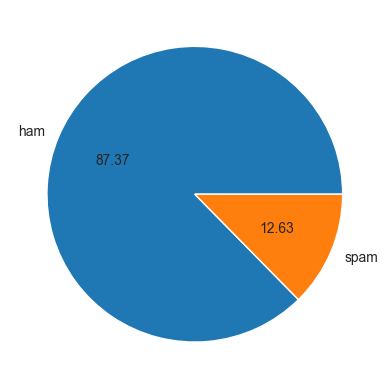

In [14]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Quindi da tale grafico si può notare che i dati non sono bilanciati

# Data Balancing

provo a bilanciare i dati, andando a fare un clustering. Dopo aver eseguito il clustering, ed avere individuato i migliori clustering, ovvero quelli più rappresentativi grazie silhouette, vado a selezionare un pò di dati da questi cluster.
L'indice silhouette è una misura usata per valutare la qualità della clusterizzazione dei dati in un problema di clustering. È spesso utilizzato per valutare quanto bene i dati sono stati assegnati ai cluster. 

Il punteggio silhouette varia da -1 a 1, dove:

- Valori vicini a 1 indicano che il campione è stato assegnato correttamente al cluster.
- Valori vicini a 0 indicano che il campione è vicino ai confini tra due cluster.
- Valori vicini a -1 indicano che il campione è stato assegnato erroneamente al cluster sbagliato.
- In generale, un valore silhouette più alto è indicativo di una migliore clusterizzazione. 

In [15]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score

# Divido il dataframe in due parti separate ham/spam
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# Eseguo il clustering dei campioni "ham" con K-Means (ML non supervisionato)
num_clusters = 3 # ho scelto un numero di cluster in base ai valori medi della silhouette (valutazione empirica)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))

# Calcolo il valore della Silhouette per ciascun campione
sample_silhouette_values = silhouette_samples(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Calcola la Silhouette Score media per tutti i campioni nella classe "ham"
silhouette_avg = silhouette_score(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Trovo i cluster con Silhouette Score più alti
best_clusters = []
for cluster_id in range(num_clusters):
    cluster_silhouette_values = sample_silhouette_values[ham['cluster'] == cluster_id]
    avg_silhouette = np.mean(cluster_silhouette_values)
    best_clusters.append((cluster_id, avg_silhouette))

for cluster_id, avg_silhouette in best_clusters:   #stampa usata per vedere i valori della silhouette
    print(f"Cluster {cluster_id}: Silhouette Score medio = {avg_silhouette}")

# Ordino i cluster in base alla Silhouette Score in ordine decrescente
best_clusters = sorted(best_clusters, key=lambda x: x[1], reverse=True)

# Scelgo i primi 2 cluster (i migliori) come cluster rappresentativi
representative_clusters = [cluster[0] for cluster in best_clusters[:2]] 

# Eseguo l'undersampling dai cluster rappresentativi, ovvero prendo solo un tot di righe da essi.

undersampled_ham = pd.DataFrame() #creo un nuovo dataframe

num_samples_per_cluster = 320  # Numero di campioni da campionare da ciascun cluster rappresentativo

#vado a selezionare 320 campioni dai due cluster migliori, e li inserisco nel dataframe undersampled_ham.
for cluster_id in representative_clusters:
    cluster_samples = ham[ham['cluster'] == cluster_id]
    # Eseguo l'undersampling (campiona da ciascun cluster rappresentativo)
    cluster_samples = resample(cluster_samples, replace=False, n_samples=num_samples_per_cluster, random_state=42)
    # Aggiungo i campioni campionati all'insieme di campioni sottocampionati
    undersampled_ham = pd.concat([undersampled_ham, cluster_samples])

# Combina l'undersampled classe "ham" con il dataframe che contiene la classe "spam" per ottenere il dataset bilanciato
df_undersampled = pd.concat([undersampled_ham, spam])

# Ora df_undersampled contiene il dataset bilanciato, quindi copio in variabile df, ovvero il df che uso di default.

df = df_undersampled


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_26332/3964754592.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))


Cluster 0: Silhouette Score medio = 0.7161829047838745
Cluster 1: Silhouette Score medio = 0.5637247761916004
Cluster 2: Silhouette Score medio = 0.4141281961571676


Basandomi sui punteggi della Silhouette Score media:

- 2 cluster: Cluster 0 con Silhouette Score medio 0.716 e Cluster 1 con Silhouette Score medio 0.564.
- 3 cluster: Cluster 0 con Silhouette Score medio 0.716, Cluster 1 con Silhouette Score medio 0.564, e Cluster 2 con Silhouette Score medio 0.414.
- 5 cluster: il Cluster 1 ha ottenuto il punteggio Silhouette Score medio più alto (0.740), ma anche il Cluster 3 ha ottenuto un punteggio elevato (0.716).
- 
Tra le opzioni di 2 cluster, 3 cluster e 5 cluster, mi è sembrato opportuno fare una suddivisione in 3 cluster in modo da avere una varietà abbastanza alta, e andare a prelevare campioni dai due cluster più rappresentativi. 

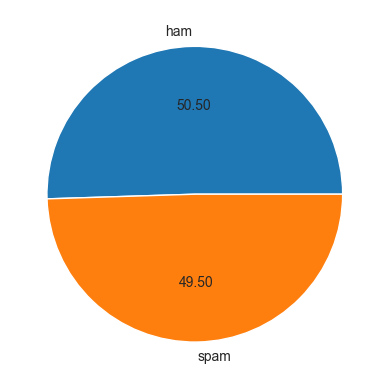

In [16]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [17]:
df['target'].value_counts()

target
1    653
0    640
Name: count, dtype: int64

ora posso andare copiare tutto su df, eliminando la colonna cluster dato che non mi servirà più

In [18]:
df = df_undersampled.drop(columns=['cluster'])
df.sample(5)

,target,text
5254,0,I didnt get anything da
4327,1,Congrats! 2 mobile 3G Videophones R yours. cal...
5366,1,A å£400 XMAS REWARD IS WAITING FOR YOU! Our co...
1455,1,Summers finally here! Fancy a chat or flirt wi...
230,0,Get down in gandhipuram and walk to cross cut ...


In [19]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ho scaricato la libreria Nltk Python ampiamente utilizzata per il trattamento del linguaggio naturale. Tra gli strumenti presenti, c'è il tokenizer NLTK denominato "Punkt" che viene utilizzato per la suddivisione di testo in frasi ed è molto utile quando si desidera suddividere un testo in frasi al fine di analizzarle o elaborarle in modo più dettagliato.

ora vado a vedere la lungehzza in caratteri di ogni messaggio 

In [20]:
df['text'].apply(len) 


85       55
1165     43
2300     72
2062     31
330      22
       ... 
5537     90
5540    160
5547    160
5566    147
5567    161
Name: text, Length: 1293, dtype: int64

quindi creo una nuova colonna nel dataset in cui indico il numero di caratteri e stampo un sample per vedere che tutto ha funzionato

In [21]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
85,0,"I call you later, don't have network. If urgnt...",55
1165,0,"Haha yeah I see that now, be there in a sec",43
2300,0,Nothin comes to my mind. ÌÏ help me buy hanger...,72
2062,0,Is there any training tomorrow?,31
330,0,K.k:)apo k.good movie.,22


vado ora a calcolare il numero di parole in ogni messaggio, utilizzando il tokenizer della libreria nltk. Vado anche qui a creare una colonna.

In [22]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
85,0,"I call you later, don't have network. If urgnt...",55,16
1165,0,"Haha yeah I see that now, be there in a sec",43,12
2300,0,Nothin comes to my mind. ÌÏ help me buy hanger...,72,18
2062,0,Is there any training tomorrow?,31,6
330,0,K.k:)apo k.good movie.,22,7


vado ora a calcolare il numero di frasi per ogni messaggio e metto i dati in una nuova colonna

In [23]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
85,0,"I call you later, don't have network. If urgnt...",55,16,2
1165,0,"Haha yeah I see that now, be there in a sec",43,12,1
2300,0,Nothin comes to my mind. ÌÏ help me buy hanger...,72,18,3
2062,0,Is there any training tomorrow?,31,6,1
330,0,K.k:)apo k.good movie.,22,7,1


stampo un grafico che mi faccia vedere le differenze di caratteri tra sms ham/spam.

<Axes: xlabel='num_characters', ylabel='Count'>

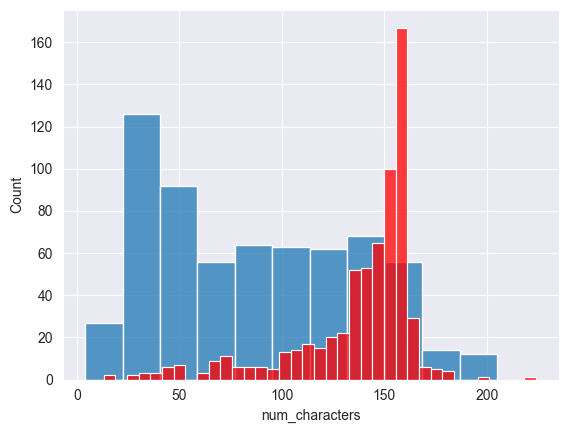

In [24]:
import seaborn as sns
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')


Quindi si può notare che i messaggi spam in media hanno un numero di caratteri abbastanza alto.

Ora vado a stampare lo stesso tipo di grafico, ma per il numero di parole.

<Axes: xlabel='num_words', ylabel='Count'>

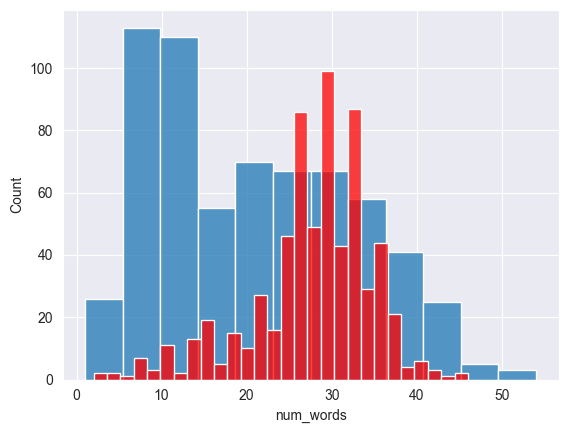

In [25]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

Inoltre come si può notare da tale grafico, i messaggi spam hanno in media decisamente più parole. Difatti si verifica, come si può notare dalle colonne rosse, che addirittura in 100 esemplari spam il testo sia di oltre 30 words. Mentre nei messagi legittimi (ham) il numero di words è decisamente poiù basso.

Ora stampo un grafico riassuntivo, un pairplot.
In un pairplot, ciascuna variabile numerica presente nel dataset viene confrontata con tutte le altre variabili numeriche tramite grafici a dispersione, quindi vengono mostrati i punti di dati lungo l'incrocio di tutte le variabili, consentendo di visualizzare e individuare eventuali relazioni o tendenze tra le variabili.

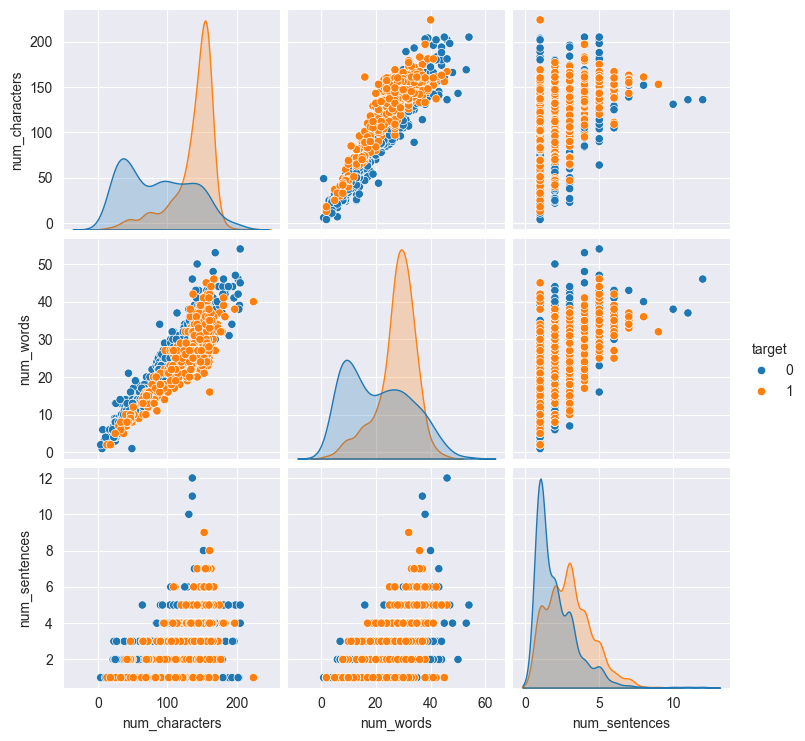

In [26]:
sns.pairplot(df, hue='target')

Emerge dal pairplot:
- sms spam hanno in media un numero di caratteri maggiore dei messaggi ham
- sms spam hanno in media un numero di word maggiore rispetto ai messaggi ham
- il numero di frasi è invece prevalentemente maggiore negli sms ham.

Vado a visualizzare gli stessi dati con la matrice di correlazione, che mi restituisce le correlazioni tra le variabili del dataset, prima di fare ciò devo escludere dal dataframe la colonna text

In [27]:
df_without_text = df.drop(columns=["text"])
df_without_text.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.532585,0.336154,0.298251
num_characters,0.532585,1.000000,0.924791,0.499564
num_words,0.336154,0.924791,1.000000,0.565660
num_sentences,0.298251,0.499564,0.565660,1.000000


vado a rappresentare tali valori con una heatmap che utilizza colori per visualizzare i valori dei coefficienti di correlazione tra le diverse coppie di variabili nel dataset, consentendo di individuare facilmente relazioni tra di esse.
All'interno della mappa:
- Le celle più scure o più chiare indicano correlazioni più forti o più deboli, rispettivamente. 
- le variabili che sono fortemente correlate tra loro (valori vicini a 1 o -1) o variabili che hanno una bassa correlazione (valori vicini a 0).

<Axes: >

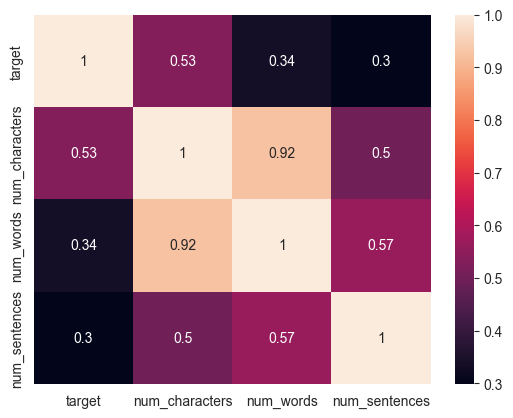

In [28]:
sns.heatmap(df_without_text.corr(), annot=True)

Dalla heatmap emergono svariate considerazioni facilemente spiegabili: 
- forte correlazioni tra numero di parole e numero di caratteri
- il fatto che possa esserci correlazione tra il numero di caratteri e il fatto che un messaggio possa essere ham/spam


# Preprocessing dei dati (Data cleaning)

Rientra nella fase di pulizia dei dati, e vado ad eseguire i seguenti passaggi:
- portare tutto il testo in miniscolo
- tokenizzazione
- rimozione caratteri speciali
- rimozione punteggiatura e stopwords
- stemming (sostituire le parole con la loro radice)

Creo una funzione che esegua tutti questi passi, che prenda in input del testo, e mi restituisca in output del testo preprocessato, ovvero minuscolo, tokenizzato, senza caratteri speciali e stopword, con tutte le words riporatte alla forma base.

In [43]:
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#stemmer utilizzato per ridurre le parole alla loro forma di base (stemma/radice).
ps = PorterStemmer() 



def transform_text(text):
    text = text.lower() #trasforma tutto in minuscolo per una maggiore coerenza durante l'analisi
    text = nltk.word_tokenize(text) #Utilizza la tokenizzazione per suddividere il testo in una lista di parole (token).
    
    #Rimuove i caratteri non alfanumerici (simboli che non sono né lettere dell'alfabeto né numeri) mantenendo solo le parole alfanumeriche.
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    # Rimuove le stopwords (parole comuni senza un significato specifico) e la punteggiatura.
    #Le stopwords sono parole comuni considerate insignificanti ai fini dell'analisi del testo perché sono molto frequenti in una lingua, ma portano con sé poco significato (come gli articoli, le preposizioni, le congiunzioni ecc. ).
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    #Esegue lo stemming delle parole (riduzione alla forma base/radice utile per ridurre le variazioni delle parole semplificando così l'analisi del testo
    for i in text:
        y.append(ps.stem(i))
    
    #Restituisce il testo pre-elaborato come una stringa di parole separate tra spazi.        
    return " ".join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


test funzione su più frasi:

In [51]:
transform_text('"Data scientists use tools like Python, R, and SQL to analyze large datasets, employing machine learning algorithms to extract valuable insights and patterns!"')

'data scientist use tool like python r sql analyz larg dataset employ machin learn algorithm extract valuabl insight pattern'

In [57]:
transform_text('URGENT!! 🚨 Your 100 % FREE PRIZE awaits! Claim NOW by texting "WIN" to 555-1234. Don t miss this EXCLUSIVE offer! 🎁🌟')

'urgent 100 free prize await claim text win miss exclus offer'

Ora procedo a trasformare il testo di tutti gli sms presenti nel dataset, e li inserisco in una nuova colonna.


In [59]:
df['text'].apply(transform_text)

85                            call later network urgnt sm
1165                                    haha yeah see sec
2300    nothin come mind ìï help buy hanger lor ur lap...
2062                                       train tomorrow
330                                              apo movi
                              ...                        
5537    want explicit sex 30 sec ring 02073162414 cost...
5540    ask 3mobil 0870 chatlin inclu free min india c...
5547    contract mobil 11 mnth latest motorola nokia e...
5566    remind o2 get pound free call credit detail gr...
5567    2nd time tri 2 contact u pound prize 2 claim e...
Name: text, Length: 1293, dtype: object

In [60]:
df['transformed_text'] = df['text'].apply(transform_text)

In [61]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
85,0,"I call you later, don't have network. If urgnt...",55,16,2,call later network urgnt sm
1165,0,"Haha yeah I see that now, be there in a sec",43,12,1,haha yeah see sec
2300,0,Nothin comes to my mind. ÌÏ help me buy hanger...,72,18,3,nothin come mind ìï help buy hanger lor ur lap...
2062,0,Is there any training tomorrow?,31,6,1,train tomorrow
330,0,K.k:)apo k.good movie.,22,7,1,apo movi
